In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))

import shap
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from utils import load_pairs_from_csv
from modules import ResNetRankNetWithAuxiliary
from datasets import FlowPhotoDatasetWithAuxiliary, FlowPhotoRankingPairsDatasetWithAuxiliary

/home/jeff/miniconda3/envs/fpe-rank/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

Confirm dataset class is working as expected. Should return image pairs and auxiliary features.

In [2]:
pairs_df = load_pairs_from_csv('/home/jeff/data/fpe/experiments/20241113-WB0-aux/runs/aux_01/input/train-pairs.csv')
pairs_df.head()

,split,pair,image_id_1,timestamp_1,filename_1,image_id_2,timestamp_2,filename_2,label,obs_1,...,obs_2,prcp_2,jday_2,dhour_2,zero_2,rand_2,obs_z_2,prcp_z_2,jday_z_2,dhour_z_2
0,train,18,664978,2022-07-13 20:45:01,imagesets/6cd6870a-0260-4687-840d-1ac4ac2794e4...,442036,2022-02-08 18:00:00,imagesets/e8d465f6-5784-4231-967f-9000428e9748...,-1,-0.065502,...,1.139879,0.00,39,13.000000,0,0.553448,0.508599,0.000000,0.104396,0.500012
1,train,18,442036,2022-02-08 18:00:00,imagesets/e8d465f6-5784-4231-967f-9000428e9748...,664978,2022-07-13 20:45:01,imagesets/6cd6870a-0260-4687-840d-1ac4ac2794e4...,1,1.139879,...,-0.065502,11.81,194,16.750278,0,0.452459,0.234521,0.179429,0.530220,0.812542
2,train,30,2018327,2023-03-07 22:30:01,imagesets/27aae6d9-9417-4b53-bf6a-cd2ce8139ba1...,660978,2022-06-06 21:15:01,imagesets/cb2b67b0-0f07-4351-b96d-2659d5b56c9f...,1,1.152288,...,0.553859,0.00,157,17.250278,0,0.429406,0.375350,0.000000,0.428571,0.854210
3,train,30,660978,2022-06-06 21:15:01,imagesets/cb2b67b0-0f07-4351-b96d-2659d5b56c9f...,2018327,2023-03-07 22:30:01,imagesets/27aae6d9-9417-4b53-bf6a-cd2ce8139ba1...,-1,0.553859,...,1.152288,0.00,66,17.500278,0,0.692919,0.511421,0.000000,0.178571,0.875043
4,train,33,1645271,2023-01-01 22:29:59,imagesets/265292ae-007e-4a94-a86c-e01028d85c1f...,2084157,2023-04-15 12:15:01,imagesets/e33129ab-64df-48f7-9380-1be3258b577f...,0,1.260087,...,1.170242,4.66,105,8.250278,0,0.821098,0.515503,0.070799,0.285714,0.104192


In [3]:
train_df = pairs_df[pairs_df['split'] == "train"]
train_df.head()

,split,pair,image_id_1,timestamp_1,filename_1,image_id_2,timestamp_2,filename_2,label,obs_1,...,obs_2,prcp_2,jday_2,dhour_2,zero_2,rand_2,obs_z_2,prcp_z_2,jday_z_2,dhour_z_2
0,train,18,664978,2022-07-13 20:45:01,imagesets/6cd6870a-0260-4687-840d-1ac4ac2794e4...,442036,2022-02-08 18:00:00,imagesets/e8d465f6-5784-4231-967f-9000428e9748...,-1,-0.065502,...,1.139879,0.00,39,13.000000,0,0.553448,0.508599,0.000000,0.104396,0.500012
1,train,18,442036,2022-02-08 18:00:00,imagesets/e8d465f6-5784-4231-967f-9000428e9748...,664978,2022-07-13 20:45:01,imagesets/6cd6870a-0260-4687-840d-1ac4ac2794e4...,1,1.139879,...,-0.065502,11.81,194,16.750278,0,0.452459,0.234521,0.179429,0.530220,0.812542
2,train,30,2018327,2023-03-07 22:30:01,imagesets/27aae6d9-9417-4b53-bf6a-cd2ce8139ba1...,660978,2022-06-06 21:15:01,imagesets/cb2b67b0-0f07-4351-b96d-2659d5b56c9f...,1,1.152288,...,0.553859,0.00,157,17.250278,0,0.429406,0.375350,0.000000,0.428571,0.854210
3,train,30,660978,2022-06-06 21:15:01,imagesets/cb2b67b0-0f07-4351-b96d-2659d5b56c9f...,2018327,2023-03-07 22:30:01,imagesets/27aae6d9-9417-4b53-bf6a-cd2ce8139ba1...,-1,0.553859,...,1.152288,0.00,66,17.500278,0,0.692919,0.511421,0.000000,0.178571,0.875043
4,train,33,1645271,2023-01-01 22:29:59,imagesets/265292ae-007e-4a94-a86c-e01028d85c1f...,2084157,2023-04-15 12:15:01,imagesets/e33129ab-64df-48f7-9380-1be3258b577f...,0,1.260087,...,1.170242,4.66,105,8.250278,0,0.821098,0.515503,0.070799,0.285714,0.104192


In [4]:
train_ds = FlowPhotoRankingPairsDatasetWithAuxiliary(
    train_df, 
    '/home/jeff/data/fpe/images/',
    auxiliary_features=['obs_z']
)
train_ds

In [5]:
img1, img2, aux1, aux2, label = train_ds[0]

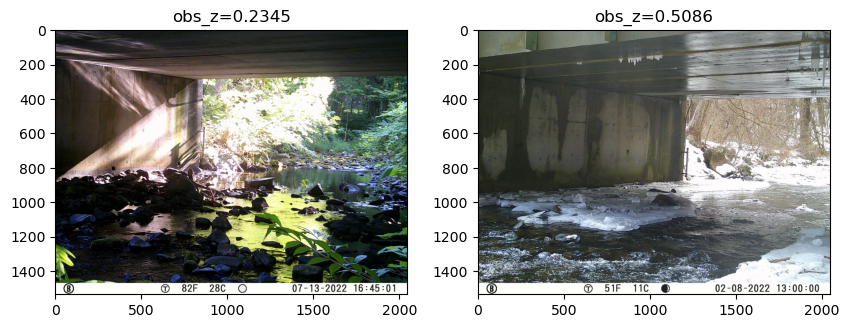

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img1.permute(1, 2, 0).numpy())
axes[0].set_title(f"obs_z={aux1.tolist()[0]:.4f}")
axes[1].imshow(img2.permute(1, 2, 0).numpy())
axes[1].set_title(f"obs_z={aux2.tolist()[0]:.4f}")
plt.show()

In [7]:
train_dl = DataLoader(
    train_ds,
    batch_size=1,
    shuffle=False
)
batch = next(iter(train_dl))
batch

[tensor([[[[0.0863, 0.0941, 0.0980,  ..., 0.0549, 0.0549, 0.0549],
           [0.1020, 0.1059, 0.1059,  ..., 0.0588, 0.0510, 0.0510],
           [0.1176, 0.1176, 0.1137,  ..., 0.0549, 0.0471, 0.0431],
           ...,
           [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
           [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
           [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961]],
 
          [[0.0824, 0.0902, 0.0980,  ..., 0.0627, 0.0627, 0.0627],
           [0.1020, 0.1059, 0.1059,  ..., 0.0667, 0.0667, 0.0667],
           [0.1137, 0.1137, 0.1098,  ..., 0.0706, 0.0706, 0.0667],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
          [[0.1451, 0.1529, 0.1451,  ..., 0.0588, 0.0588, 0.0588],
           [0.1490, 0.1529, 0.1451,  ..., 0.0627, 0.0627, 0.0627],
           [0.1451, 0.14

# Feature Importance

Use SHAP to explain the model's predictions from trained model.

In [8]:
# Load trained model -- copied from test_aux
device = 'cuda'
model_path = '/home/jeff/data/fpe/experiments/20241113-WB0-aux/runs/aux_01/model/model.pth'
checkpoint = torch.load(model_path, map_location=device)
params = checkpoint['params']
auxiliary_features = params.get('auxiliary_features', [])
model = ResNetRankNetWithAuxiliary(
    input_shape=(3, params['input_shape'][0], params['input_shape'][1]),
    transforms=checkpoint['transforms'],
    resnet_size=18,
    truncate=2,
    auxiliary_size=len(auxiliary_features),
    auxiliary_encoding_size=params.get('auxiliary_encoding_size', 32)
)

model = nn.DataParallel(model)

# Load trained weights
model.load_state_dict(checkpoint["model_state_dict"])

# Store auxiliary features for dataset creation
model.module.auxiliary_features = auxiliary_features

model = model.to(device).eval()

/tmp/ipykernel_2124101/2288746672.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


In [28]:
# Get first training pair
img1, img2, aux1, aux2, label = batch

#model.module.forward_single(img1, aux1, label)
model.forward(img1, img2, aux1, aux2)

class ModelWrapper:
    def __init__(self, model):
        self.model = model.module if isinstance(model, torch.nn.DataParallel) else model

    def __call__(self, data):
        img, aux = data
        return self.model.forward_single(img, aux)

    def named_parameters(self):
        return self.model.named_parameters()

    def eval(self):
        return self.model.eval()

# Initialize the model wrapper
model_wrapper = ModelWrapper(model)

# Initialize SHAP explainer
explainer = shap.DeepExplainer(model_wrapper, (img1, aux1))

# Compute SHAP values
#shap_values = explainer.shap_values((img1, aux1))

# Plot SHAP values for the auxiliary feature
#shap.summary_plot(shap_values[1], aux1.numpy(), feature_names=["obs_z"])

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor